In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import loadmat
from spectral import *
from functions import *
import warnings
import time

In [13]:
def causal_get_cov_loc(order=[2,2]):
    cov_loc = []
    p = order[0]
    q = order[1]
    for i in range(-p,1):
        for j in range(-q,1):
            if((i==0) & (j==0)): continue
            cov_loc.append([i,j])
    return cov_loc

In [23]:
def causal_fast_2d_AR_leverage_score(image, order=[2,2], subsample_size = 1000):
    p = order[0]
    q = order[1]
    [m,n] = image.shape

    lev = np.zeros([m,n])
    lev_temp = np.zeros([m-p,n-q])
    cov_loc = causal_get_cov_loc(order)
    XX = np.zeros([(m-p), (n-q),len(cov_loc)])
    i = 0
    for loc in cov_loc:
        k = loc[0]
        l = loc[1]
        XX[:,:,i] = image[(p+k):(m+k), (q+l):(n+l)]
        i = i + 1
    
    lev_temp = XX[:,:,0]**2 / np.sum(XX[:,:,0]**2)
    phi = np.sum(XX[:,:,0] * XX[:,:,1]) / np.sum(XX[:,:,0]**2)
    residual = XX[:,:,1] - XX[:,:,0] * phi
    lev_temp = lev_temp + np.power(residual,2) / np.sum(np.power(residual,2))

    for s in range(2,len(cov_loc)):
        phi = two_dim_param_estiamte_leverage(XX[:,:,:s], XX[:,:,s], lev_score = lev_temp, subsample_size = subsample_size)
        residual = XX[:,:,s] - tensor_vec_multiply(XX[:,:,:s], phi)
        lev_temp = lev_temp + np.power(residual,2) / np.sum(np.power(residual,2))

    lev[p:,q:] = lev_temp
    return lev

In [79]:
m = 2000
n = 2000
Y = np.zeros([m,n])
p = 2
q = 2
order = [p,q]

SEED = 42
np.random.seed(SEED)
Y[0,:] = 0.1*np.random.randn(n) + 1
Y[1,:] = 0.1*np.random.randn(n) + 0.5
Y[:,0] = 0.1*np.random.randn(m) + 0.1
Y[:,1] = 0.1*np.random.randn(m) + 0.2
beta = np.array([[0.01,-0.02,0.03],[-0.04,0.05,-0.06],[0.07,-0.08,0]])

for i in range(p,m):
    for j in range(q,n):
        Y[i,j] = np.sum(Y[(i-p):(i+1),(j-q):(j+1)] * beta) + 0.01 * np.random.randn(1)

C:\Users\penlux\AppData\Local\Temp\ipykernel_11832\1431028748.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i,j] = np.sum(Y[(i-p):(i+1),(j-q):(j+1)] * beta) + 0.01 * np.random.randn(1)


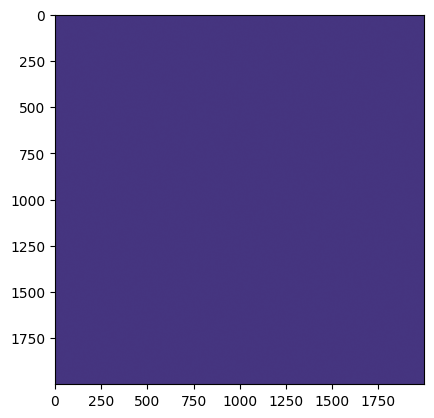

In [42]:
plt.imshow(Y)

In [59]:
subsample_size = 1000
image = Y
p = order[0]
q = order[1]
[m,n] = image.shape

cov_loc = causal_get_cov_loc(order)
XX = np.zeros([(m-p), (n-q),len(cov_loc)])
i = 0
for loc in cov_loc:
    k = loc[0]
    l = loc[1]
    XX[:,:,i] = image[(p+k):(m+k), (q+l):(n+l)]
    i = i + 1

In [72]:
phi = beta.reshape(-1)[0:(p*q+p+q)]

start_fast = time.time()
leverage_score = causal_fast_2d_AR_leverage_score(Y, order=order, subsample_size = subsample_size)
phi_fast = two_dim_param_estiamte_leverage(XX, Y[2:,2:], lev_score = leverage_score[2:,2:], subsample_size = subsample_size)
end_fast = time.time()
time_fast = end_fast - start_fast
MSE_fast = np.sqrt(np.sum((phi - phi_fast)**2))

start_OLS = time.time()
phi_OLS = two_dim_param_estiamte_leverage(XX, Y[2:,2:])
end_OLS = time.time()
time_OLS = end_OLS - start_OLS
MSE_OLS = np.sqrt(np.sum((phi - phi_OLS)**2))

start_random = time.time()
phi_random = two_dim_param_estiamte_leverage(XX, Y[2:,2:], lev_score = np.ones([m-p,n-q]), subsample_size = subsample_size)
end_random = time.time()
time_random = end_random - start_random
MSE_random = np.sqrt(np.sum((phi - phi_random)**2))

In [94]:
nrep = 10
SEED = 42
np.random.seed(SEED)

MSE_fast = np.zeros(nrep)
MSE_OLS = np.zeros(nrep)
MSE_random = np.zeros(nrep)
time_fast = np.zeros(nrep)
time_OLS = np.zeros(nrep)
time_random = np.zeros(nrep)

m = 2000
n = 2000
Y = np.zeros([m,n])
p = 2
q = 2
order = [p,q]
beta = np.array([[0.01,-0.02,0.03],[-0.04,0.05,-0.06],[0.07,-0.08,0]])
phi = beta.reshape(-1)[0:(p*q+p+q)]

subsample_size = 1000

for r in range(nrep):
    Y[0,:] = 0.1*np.random.randn(n) + 1
    Y[1,:] = 0.1*np.random.randn(n) + 0.5
    Y[:,0] = 0.1*np.random.randn(m) + 0.1
    Y[:,1] = 0.1*np.random.randn(m) + 0.2
    for i in range(p,m):
        for j in range(q,n):
            Y[i,j] = np.sum(Y[(i-p):(i+1),(j-q):(j+1)] * beta) + 0.01 * np.random.randn(1)

    cov_loc = causal_get_cov_loc(order)
    XX = np.zeros([(m-p), (n-q),len(cov_loc)])
    i = 0
    for loc in cov_loc:
        k = loc[0]
        l = loc[1]
        XX[:,:,i] = Y[(p+k):(m+k), (q+l):(n+l)]
        i = i + 1

    print(r)

    start_fast = time.time()
    leverage_score = causal_fast_2d_AR_leverage_score(Y, order=order, subsample_size = subsample_size)
    phi_fast = two_dim_param_estiamte_leverage(XX, Y[2:,2:], lev_score = leverage_score[2:,2:], subsample_size = subsample_size)
    end_fast = time.time()
    time_fast[r] = end_fast - start_fast
    MSE_fast[r] = np.sqrt(np.sum((phi - phi_fast)**2))

    start_OLS = time.time()
    phi_OLS = two_dim_param_estiamte_leverage(XX, Y[2:,2:]).reshape(-1)
    end_OLS = time.time()
    time_OLS[r] = end_OLS - start_OLS
    MSE_OLS[r] = np.sqrt(np.sum((phi - phi_OLS)**2))

    start_random = time.time()
    phi_random = two_dim_param_estiamte_leverage(XX, Y[2:,2:], lev_score = np.ones([m-p,n-q]), subsample_size = subsample_size)
    end_random = time.time()
    time_random[r] = end_random - start_random
    MSE_random[r] = np.sqrt(np.sum((phi - phi_random)**2))
    

C:\Users\penlux\AppData\Local\Temp\ipykernel_11832\3965347127.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i,j] = np.sum(Y[(i-p):(i+1),(j-q):(j+1)] * beta) + 0.01 * np.random.randn(1)


0
1
2
3
4
5
6
7
8
9


In [95]:
print(time_fast)
print(time_OLS)
print(time_random)

[4.25602484 3.97227955 3.95560098 3.8900044  4.08768678 3.96511626
 4.94208026 4.30575156 3.92749    4.15729737]
[2.16706824 1.71200395 1.71209359 1.69497442 1.7291162  1.66522813
 2.02400327 1.73857212 1.66252232 1.76036048]
[0.09669113 0.1002202  0.08520055 0.07037544 0.09990597 0.07810664
 0.08597779 0.0708735  0.07249761 0.08417511]


In [96]:
print(MSE_fast)
print(MSE_OLS)
print(MSE_random)

[0.01706922 0.01146546 0.01705481 0.01653791 0.01112756 0.01587326
 0.01242293 0.01671222 0.01528009 0.0096383 ]
[0.00152986 0.00138396 0.00092874 0.00113327 0.00166264 0.00096314
 0.00115539 0.0011503  0.00116297 0.00070625]
[0.07035287 0.05842887 0.11956492 0.08804475 0.09888815 0.06616633
 0.04598308 0.07752591 0.07063562 0.06479366]
